In [1]:
from deepsudoku import REPO_PATH
import os
os.chdir(REPO_PATH)
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import tqdm
from deepsudoku.generate import Solver

In [35]:
dfs = []


for path in glob.glob("data/*/*.txt"):
    
    
    with open(path, "r") as f:
        
        lines = f.readlines()
        lines = [i.replace("\n", "").split() for i in lines if '#' not in i]

    quizzes = [l[0] for l in lines]
    solutions = [l[1] for l in lines]

    df = pd.DataFrame({'quiz': quizzes,
                    'solution': solutions})

    name = Path(path).parent.name

    df["difficulty"] = name[:name.find("_")]
    df["considering_density"] = name[name.find("_")+1:] == "considering_density"

    dfs.append(df)
    
our_data = pd.concat(dfs)
our_data["origin"] = "our_data"
our_data.describe()

,quiz,solution,difficulty,considering_density,origin
count,1900000,1900000,1900000,1900000,1900000
unique,1900000,1900000,5,2,1
top,.5...6289..3........65.9..1..4.129689.284..7.3...,1574362894932816578265794315743129689628451733...,insane,True,our_data
freq,1,1,1000000,1000000,1900000


<Axes: xlabel='difficulty'>

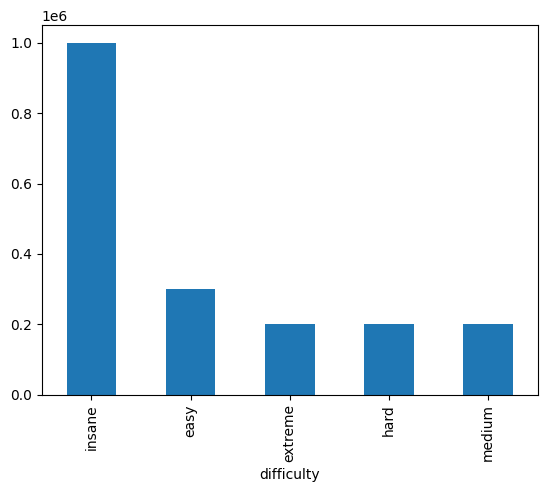

In [36]:
our_data.value_counts("difficulty").plot.bar()

In [38]:
our_data["missing_cells"] = our_data.quiz.apply(lambda x: x.count("."))
our_data.groupby("difficulty")["missing_cells"].describe()

,count,mean,std,min,25%,50%,75%,max
difficulty,,,,,,,,
easy,300000.0,26.997473,0.105800,16.0,27.0,27.0,27.0,27.0
extreme,200000.0,53.270225,2.495268,32.0,52.0,54.0,55.0,60.0
hard,200000.0,48.351830,2.620973,26.0,47.0,49.0,50.0,58.0
insane,1000000.0,56.359856,1.514768,34.0,56.0,57.0,57.0,61.0
medium,200000.0,43.196935,2.386254,21.0,42.0,44.0,45.0,46.0


In [46]:
dfs = []

for path in glob.glob("tdoku/data/*"):
    
    with open(path, "r") as f:
    
        lines = f.readlines()
        lines = [i.replace("\n", "") for i in lines if '#' not in i]
        
    
    solver = Solver()
        
    solution = []
    quiz = []

    for line in tqdm.tqdm(lines):
        
        if solver.Count(line) != 1:
            continue
        
        res = solver.Solve(line)
        
        if res[0]:
            solution.append(res[1])
            quiz.append(line)
        
    if solution:
            
        df = pd.DataFrame({'quiz': quiz,
                        'solution': solution})

        name = Path(path).name
        origin = f"tdoku_data_{name[name.find('_')+1:]}"
        
        df["origin"] = origin
        
        dfs.append(df)
    
tdoku_data = pd.concat(dfs)
tdoku_data.groupby("origin").count()

100%|██████████| 2135371/2135371 [02:22<00:00, 14994.13it/s]


,quiz,solution
origin,,
tdoku_data_17_clue,49158,49158
tdoku_data_forum_hardest_1106,375,375
tdoku_data_forum_hardest_1905,2135371,2135371
tdoku_data_forum_hardest_1905_11+,48766,48766
tdoku_data_gen_puzzles,763,763
tdoku_data_kaggle,100000,100000
tdoku_data_magictour_top1465,1465,1465
tdoku_data_unbiased,1000000,1000000


In [47]:
all_data = pd.concat([our_data, tdoku_data])
all_data.index = np.arange(len(all_data))

In [53]:
all_data["data_type"] = "test"

for origin in all_data.origin.unique():
    
    if origin == "our_data":
        
        continue
    
    data = all_data.query("origin == @origin")
    
    if len(data) < 50000:
        continue
    
    first_80 = int(len(data)*0.8)
    till_90 = int(len(data)*0.9)
    
    all_data.loc[data.index[:first_80],"data_type"] = "train"
    all_data.loc[data.index[first_80:till_90],"data_type"] = "val"
    

our_data = all_data.query("origin == 'our_data'")

for difficulty in our_data.difficulty.unique():
    
    data = our_data.query("difficulty == @difficulty")
    
    first_80 = int(len(data)*0.8)
    till_90 = int(len(data)*0.9)
    
    all_data.loc[data.index[:first_80],"data_type"] = "train"
    all_data.loc[data.index[first_80:till_90],"data_type"] = "val"
    
all_data.value_counts("data_type", normalize = True)
    
    

data_type
train    0.78464
test     0.11728
val      0.09808
Name: proportion, dtype: float64

In [ ]:
all_data.to_feather("data/all_data.feather")

In [2]:
our_data = pd.read_feather("data/all_data.feather").query("origin == 'our_data'")
our_data.to_feather("data/our_data.feather")

In [2]:
old = pd.read_feather("datasets/info.feather").drop(columns=["index","input_sha","label_sha","data_type"])
quizzes = np.load("datasets/all_inputs.npy")
solutions = np.load("datasets/all_labels.npy")
old["quiz"] = ["".join(i.flatten().astype(str)) for i in tqdm.tqdm(quizzes)]
old["solution"] = ["".join(i.flatten().astype(str)) for i in tqdm.tqdm(solutions)]

100%|██████████| 1825000/1825000 [01:31<00:00, 20047.64it/s]


In [4]:
old["quiz"] = old["quiz"].apply(lambda x: x.replace("0","."))

solver = Solver()
old["solutions"] = [solver.Count(ar) for ar in tqdm.tqdm(old["quiz"])]
old["solutions"].describe()

100%|██████████| 1825000/1825000 [00:06<00:00, 288185.36it/s]


count    1825000.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: solutions, dtype: float64

In [10]:
old["checked"] = [solver.Solve(ar)[1] for ar in tqdm.tqdm(old["quiz"])]
(old["checked"] == old.solution).all()

100%|██████████| 1825000/1825000 [00:07<00:00, 247099.36it/s]


True

In [15]:
old[["quiz","solution"]].describe()

,quiz,solution
count,1825000,1825000
unique,1825000,744265
top,.7219548..4.7.21.99...387268.7321.455.498731.2...,4839157261596724837263481599152673486728349153...
freq,1,13


In [16]:
old["data_type"] = "test"

for diff in old.difficulty.unique():
    
    data = old.query("difficulty == @diff").sort_values("solution")
    
    first_80 = int(len(data)*0.8)
    till_90 = int(len(data)*0.9)
    
    old.loc[data.index[:first_80],"data_type"] = "train"
    old.loc[data.index[first_80:till_90],"data_type"] = "val"

old.data_type.value_counts(normalize=True)

data_type
train    0.8
val      0.1
test     0.1
Name: proportion, dtype: float64

In [17]:
old["origin"] = "old_data"
old.to_feather("data/old_data.feather")

In [3]:
our_data = pd.read_feather("data/our_data.feather")
old_data = pd.read_feather("data/old_data.feather")
old_diffs = old_data.value_counts("difficulty")
our_diffs = our_data.value_counts("difficulty")

In [7]:
same = np.minimum(our_diffs, old_diffs)
same.items()

In [8]:
same = np.minimum(our_diffs, old_diffs)

def make_same(df):
    
    keep = []
    
    for d,v in same.items():
        keep.append(df.query("difficulty == @d").sample(n = v).copy())

    new_df = pd.concat(keep)
    new_df.index = np.arange(len(new_df))
    return new_df

comp_our_data = make_same(our_data)
comp_old_data = make_same(old_data)
comp_old_data.value_counts("difficulty")

difficulty
insane     500000
easy       250000
extreme    200000
hard       200000
medium     200000
Name: count, dtype: int64

In [9]:
comp_old_data.value_counts("data_type", normalize= True)

data_type
train    0.799779
val      0.100207
test     0.100014
Name: proportion, dtype: float64

In [10]:
comp_our_data.value_counts("data_type", normalize= True)

data_type
train    0.799899
test     0.100077
val      0.100024
Name: proportion, dtype: float64

In [12]:
comp_our_data.to_feather("data/comp_our_data.feather")
comp_old_data.to_feather("data/comp_old_data.feather")

In [6]:
our_data = pd.read_feather("data/our_data.feather")
our_data.query("difficulty == 'easy'").reset_index(drop=True).to_feather("data/easy_only.feather")